#  Self-tuning random forests

A demonstration of ensembling and tuning in MLJ

In [21]:
# uncomment 2 lines for parallelized ensemble building:
# using Distributed
# addprocs()

using Suppressor
using MLJ
using Plots
pyplot()

Plots.PyPlotBackend()

Load a task (data plus learning objective):

In [22]:
task = load_boston()

SupervisedTask @ 5…80


To see how to construct your own task, see [Working with Tasks](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_tasks/)

Which models are available for the present task?

In [23]:
models(task)

Dict{String,Any} with 4 entries:
  "MLJ"          => Any["DecisionTreeRegressor", "KNNRegressor", "RidgeRegresso…
  "DecisionTree" => Any["DecisionTreeRegressor"]
  "ScikitLearn"  => Any["SVMRegressor", "SVMLRegressor", "SVMNuRegressor"]
  "XGBoost"      => Any["XGBoostRegressor"]

## Evaluating a single decision tree

In [4]:
@load DecisionTreeRegressor

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeRegressor ✔


In [24]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


(MLJ.rms = 7.054322052311654,
 MLJ.rmslp1 = 0.32730942581047084,)

## Creating a random forest by ensembling

In [25]:
forest = EnsembleModel(atom=tree)

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor @ 1…07,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x94b7f9a0, 0xbb91ee67, 0x50c83b74, 0x9bd94e18]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 9…83

In [26]:
@more

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor(pruning_purity_threshold = 0.0,
                                                            max_depth = -1,
                                                            min_samples_leaf = 5,
                                                            min_samples_split = 2,
                                                            min_purity_increase = 0.0,
                                                            n_subfeatures = 0,
                                                            post_prune = false,),
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x94b7f9a0, 0xbb91ee67, 0x50c83b74, 0x9bd94e18]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 9…83

We start by reducing number of features sampled at each tree node. We will use the square root of the
number of features, a common default:

In [27]:
tree.n_subfeatures = 3;

To get an idea of how many trees we need, we wrap our forest model in the task, pick a range for the ensemeble size, `n`, and generate learning curves (plots of model performance against `n`):

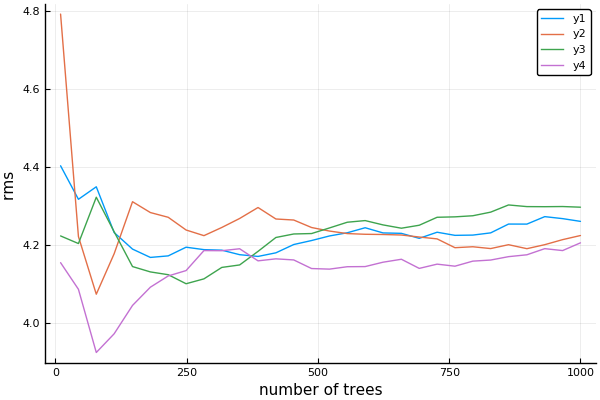

In [28]:
mach = machine(forest, task)
r = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(mach,
    resampling=Holdout(fraction_train=0.8),
    nested_range=(n=r,), 
    measure=rms, n=4,
    verbosity=0)
@suppress plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")

In [29]:
savefig("learningcurves.png")

In [30]:
forest.n = 300;

# Tuning

As `forest` is a composite model, it has nested hyperparameters:

In [31]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x94b7f9a0, 0xbb91ee67, 0x50c83b74, 0x9bd94e18]),
 n = 300,
 parallel = true,
 out_of_bag_measure = Any[],)

Let's define ranges for two hyperparameters we want to tune:

In [32]:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

We collate the ranges using by matching the pattern of `params(forest)` above, omitting parameters that don't change:

In [33]:
nested_ranges = (atom=(n_subfeatures=r1,), 
                 bagging_fraction=r2)

(atom = (n_subfeatures = NumericRange{n_subfeatures} @ 6…47,),
 bagging_fraction = NumericRange{bagging_fraction} @ 9…90,)

We now wrap our forest in tuning strategy to obtain a new "self-tuning" model!

In [34]:
tuned_forest = TunedModel(model=forest, 
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges, 
                          measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel @ 9…83,
                            tuning = Grid @ 1…77,
                            resampling = CV @ 1…41,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 6…47,), bagging_fraction = NumericRange{bagging_fraction} @ 9…90),
                            minimize = true,
                            full_report = true,) @ 1…10

In [35]:
params(tuned_forest)

(model = (atom = (pruning_purity_threshold = 0.0,
                  max_depth = -1,
                  min_samples_leaf = 5,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 3,
                  post_prune = false,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0x94b7f9a0, 0xbb91ee67, 0x50c83b74, 0x9bd94e18]),
          n = 300,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.rms,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 6…47,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 9…90,),
 minimize = true,
 full_report = true,)

## Evaluating the self-tuning random forest 

We evaluate our self-tuning random forest the same as any other model:

In [36]:
mach = machine(tuned_forest, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


(MLJ.rms = 4.081215420261934,
 MLJ.rmslp1 = 0.2549685999264012,)

Implicit in this evaluation is nested resampling: `evaluate!` fits `tuned_forest` on the training data and evaluates its performance on the 20% holdout test set. On the other hand, fitting `tuned_forest` means:
(i) searching over all parameters specified by `nested_ranges` above for the values optimizing performance, as estimated by cross-validation on the supplied data (80% of all data); and (ii)
and retraining a `forest` on all of that supplied data, using the optimal parameters.

We can view the optimal `forest` hyperparameters:

In [37]:
fitted_params(mach)

(best_model = DeterministicEnsembleModel @ 1…80,)

In [38]:
best = fitted_params(mach).best_model
@show best.bagging_fraction
@show best.atom.n_subfeatures;

best.bagging_fraction = 0.509090909090909
(best.atom).n_subfeatures = 9


And plot the performance estimates for the grid search:

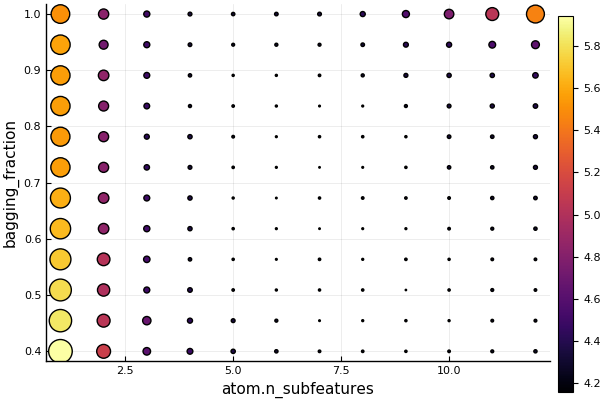

In [39]:
@suppress plot(mach)